In [1]:
import sys
from pathlib import Path
project_root = Path('..').resolve()
sys.path.insert(0, str(project_root / 'src'))

In [2]:
from riskmc.data import load_prices
from riskmc.returns import log_returns
from riskmc.simulation import mc_gaussian_returns
from riskmc.risk_metrics import var, cvar
from riskmc.plots import plot_pnl_distribution
from riskmc.data import create_data


In [3]:
assets = ['SPY', 'TLT', 'GLD', 'QQQ']
weights = [0.4, 0.3, 0.2, 0.1]
#weights chosen like this as
#equities (eg SPY) dominate risk
#bonds (eg TLT) as ballast
#gold (GLD) as hedge
#QQQ as growth tilt

N_SIMS = 100_000
HORIZON = 1

In [4]:
import numpy as np

In [5]:
project_root = Path('..').resolve()
data_out_path = project_root / 'data' / 'prices.csv'
create_data(data_out_path)


Saved 503 rows to /Users/ankithrangan/Desktop/Portfolio-risk-monte-carlo/data/prices.csv


Ticker,SPY,TLT,GLD,QQQ
Date,,,,
2026-01-12,695.159973,87.669998,422.230011,627.169983
2026-01-13,693.770020,87.820000,421.630005,626.239990
2026-01-14,690.359985,88.330002,425.940002,619.549988
2026-01-15,692.239990,88.309998,423.329987,621.780029
2026-01-16,691.659973,87.800003,421.290009,621.260010


In [6]:
prices = load_prices(data_out_path)
rets = log_returns(prices)

print(rets)

                 SPY       TLT       GLD       QQQ
Date                                              
2024-01-18  0.008853 -0.009339  0.008199  0.014094
2024-01-19  0.012389  0.003193  0.002984  0.019637
2024-01-22  0.002112  0.005934 -0.003785  0.001305
2024-01-23  0.002912 -0.007955  0.003892  0.004141
2024-01-24  0.001093 -0.005875 -0.008281  0.005534
...              ...       ...       ...       ...
2026-01-12  0.001569 -0.002961  0.018550  0.000829
2026-01-13 -0.002001  0.001710 -0.001422 -0.001484
2026-01-14 -0.004927  0.005791  0.010170 -0.010740
2026-01-15  0.002720 -0.000226 -0.006147  0.003593
2026-01-16 -0.000838 -0.005792 -0.004831 -0.000837

[502 rows x 4 columns]


In [7]:
#use this if dataset is made larger, could be more accurate
#for now, dataset too small so use [0.4, 0.3, 0.2, 0.1]
'''
vols = rets.std()
inv_vol = 1/vols
weights = inv_vol / inv_vol
weights
'''

'\nvols = rets.std()\ninv_vol = 1/vols\nweights = inv_vol / inv_vol\nweights\n'

In [8]:
print(prices)
print(rets)

                   SPY        TLT         GLD         QQQ
Date                                                     
2024-01-17  460.896179  87.060165  185.839996  402.761749
2024-01-18  464.994781  86.250923  187.369995  408.478607
2024-01-19  470.791473  86.526787  187.929993  416.579102
2024-01-22  471.786926  87.041779  187.220001  417.123138
2024-01-23  473.162872  86.352074  187.949997  418.854004
...                ...        ...         ...         ...
2026-01-12  695.159973  87.669998  422.230011  627.169983
2026-01-13  693.770020  87.820000  421.630005  626.239990
2026-01-14  690.359985  88.330002  425.940002  619.549988
2026-01-15  692.239990  88.309998  423.329987  621.780029
2026-01-16  691.659973  87.800003  421.290009  621.260010

[503 rows x 4 columns]
                 SPY       TLT       GLD       QQQ
Date                                              
2024-01-18  0.008853 -0.009339  0.008199  0.014094
2024-01-19  0.012389  0.003193  0.002984  0.019637
2024-01-22  0.0021

In [9]:
portfolio_returns = rets @ weights
print(portfolio_returns)

Date
2024-01-18    0.003789
2024-01-19    0.008474
2024-01-22    0.001999
2024-01-23   -0.000029
2024-01-24   -0.002428
                ...   
2026-01-12    0.003532
2026-01-13   -0.000721
2026-01-14    0.000726
2026-01-15    0.000150
2026-01-16   -0.003123
Length: 502, dtype: float64


In [10]:
#monte carlo sim
sim_asset_returns = mc_gaussian_returns(rets, N_SIMS, HORIZON)
sim_port_returns = sim_asset_returns @ weights

print(sim_asset_returns)
print(sim_port_returns)

[[ 0.00048316  0.00369282 -0.01138949 -0.00336907]
 [ 0.02089851 -0.00036121 -0.00865139  0.02813204]
 [ 0.00331397  0.00527063 -0.00886507  0.00074794]
 ...
 [ 0.00560301 -0.0028253  -0.00682039  0.00812502]
 [ 0.01116099 -0.00745221  0.01672363  0.01720097]
 [-0.0069513   0.00137449  0.02562306 -0.0161188 ]]
[-0.0013137   0.00933397  0.00120856 ...  0.00084204  0.00729356
  0.00114456]


In [11]:
#risk metrics
var_95 = var(sim_port_returns, 0.95)
var_99 = var(sim_port_returns, 0.99)
cvar_95 = cvar(sim_port_returns, 0.95)
cvar_99 = cvar(sim_port_returns, 0.99)

var_95, var_99, cvar_95, cvar_99

(np.float64(0.010301463774005471),
 np.float64(0.014758831289780547),
 np.float64(0.013039565041243787),
 np.float64(0.0170869146367635))

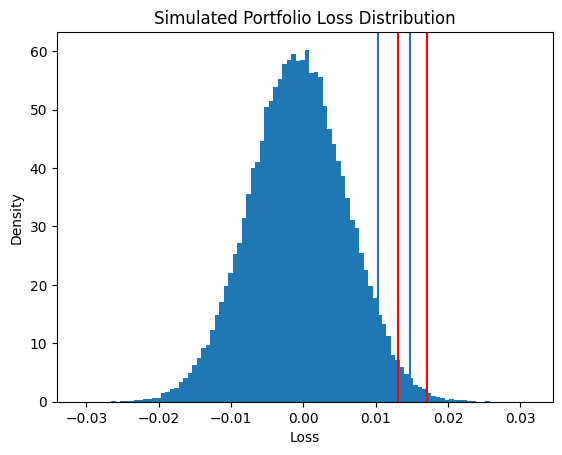

In [12]:
plot_pnl_distribution(sim_port_returns, var_95, var_99, cvar_95, cvar_99)

In [13]:
print(np.std(sim_port_returns))
print(np.mean(sim_port_returns))

0.006697143737828207
0.0007331277497879938
